In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

import itertools

from cpd_utils import *

import time
import bisect

import pandas as pd

from sklearn import linear_model
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# DCDP

In [2]:
fred = pd.read_csv('FRED.csv')

In [3]:
fred = fred.dropna(axis = "columns")

In [4]:
fred

,date,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,INVEST,VIXCLSx
0,2000-01-01,-0.002434,0.007932,-0.006763,-0.000592,-0.002811,-0.004488,-0.013108,0.017841,-0.025743,...,0.000602,0.000409,0.003036,-0.004309,0.000655,-0.001185,1.403784e-03,6.6,-0.009868,24.8430
1,2000-02-01,0.009364,-0.018159,0.014724,0.003666,0.005090,0.006240,0.007465,-0.003394,0.012017,...,0.000596,0.000406,-0.002375,0.005047,-0.000680,0.002320,-4.258847e-03,-0.7,-0.008760,25.4560
2,2000-03-01,0.004919,0.011754,0.011593,0.003790,0.002175,0.001130,-0.003713,-0.003371,-0.003805,...,0.002998,0.001161,0.004718,0.005466,-0.000673,-0.000606,1.411929e-03,-4.2,0.016952,24.7678
3,2000-04-01,-0.000295,0.008276,-0.015180,0.006214,0.008025,0.008056,0.008362,0.012836,0.006569,...,-0.007840,-0.005128,-0.003452,-0.016760,0.001973,0.001705,2.105965e-03,2.1,-0.004814,29.8331
4,2000-05-01,0.003732,-0.005321,0.001283,0.002954,0.001604,0.003450,0.001816,-0.003625,0.004059,...,0.003008,0.001673,0.001615,0.002298,-0.004625,-0.006921,-4.928346e-03,1.5,-0.002408,29.4290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2019-08-01,0.002841,0.005454,0.004785,0.006898,0.004824,0.004907,0.003430,0.010295,0.001465,...,-0.001365,-0.000864,0.004229,-0.003983,0.002824,0.005265,-1.806682e-03,-8.6,0.004553,19.4147
236,2019-09-01,0.001213,-0.001285,-0.006551,-0.003208,-0.006525,-0.008930,-0.007521,-0.019210,-0.004113,...,0.000911,0.000208,0.001978,0.001179,-0.000816,-0.001067,-8.108921e-07,3.4,0.005980,15.7324
237,2019-10-01,0.000585,-0.006168,0.003401,-0.007844,-0.004047,-0.003160,-0.002462,-0.033859,0.006454,...,0.000703,0.001648,-0.000894,0.005826,-0.000409,-0.003146,2.243860e-03,2.3,-0.017894,15.0714
238,2019-11-01,0.003286,0.004031,0.004331,0.003143,0.008942,0.012285,0.013186,0.058925,0.000080,...,-0.000464,-0.001587,-0.002434,-0.002519,-0.001206,0.001742,4.370739e-04,1.3,0.006901,12.3952


In [5]:
fred.shape

(240, 114)

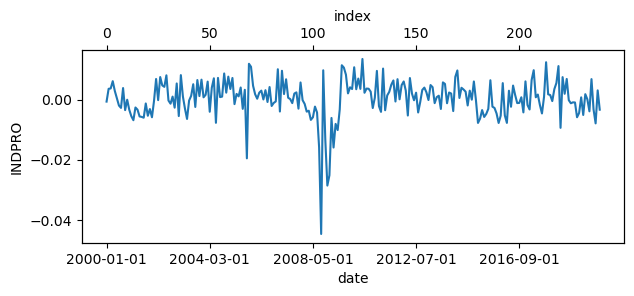

<Figure size 640x480 with 0 Axes>

In [6]:
n = fred.shape[0]
fig, ax = plt.subplots(1, 1, figsize = (7, 2.5))
ax.plot(fred.loc[:, "INDPRO"].values)

x = np.arange(0, n, 50)
y = [0] * len(x)
ax.xaxis.set_ticks(x)
for i, v in enumerate(x):
    if v < n:
        y[i] = fred.loc[:, "date"].values[int(v)]
    else:
        y[i] = ''
ax.set_xticklabels(y)
ax.set_xlabel('date')

ax2 = ax.twiny()
new_tick_locations = x.copy()

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(new_tick_locations)
ax2.set_xlabel("index")

ax.set_ylabel('INDPRO')

plt.show()

plt.savefig('FRED_INDPRO.pdf', bbox_inches = 'tight')

In [7]:
nt = len(fred)
Y = fred.loc[:, "INDPRO"].values
X = fred.drop(["date", "INDPRO"], axis = 1).values

Y_train = Y[np.arange(0, nt, 2)]
Y_test = Y[np.arange(1, nt, 2)]
X_train = X[np.arange(0, nt, 2), :]
X_test = X[np.arange(1, nt, 2), :]

In [8]:
X.shape

(240, 112)

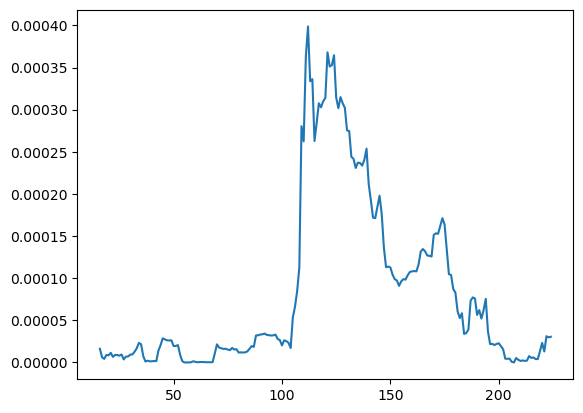

In [9]:
eda = cpd_eda_linear()
path_t_all, path_loglike_all = eda.draw_glr_path(X, Y, smooth = 16, step = 1)
plt.plot(path_t_all, path_loglike_all)
# plt.savefig('nba_glr_all_2.pdf', bbox_inches='tight')

In [10]:
ix = np.argmax(path_loglike_all)
fred["date"].values[path_t_all[ix]]

'2009-05-01'

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

std = np.std(Y_train)
mu = np.mean(Y_train)
Y_train = (Y_train - mu) / std
Y_test = (Y_test - mu) / std

In [13]:
print(Y_train.shape)
print(X_train.shape)

(120,)
(120, 112)


(array([ 1.,  0.,  0.,  1.,  2.,  2., 17., 50., 39.,  8.]),
 array([-6.24698095, -5.43252411, -4.61806727, -3.80361043, -2.9891536 ,
        -2.17469676, -1.36023992, -0.54578308,  0.26867376,  1.08313059,
         1.89758743]),
 <BarContainer object of 10 artists>)

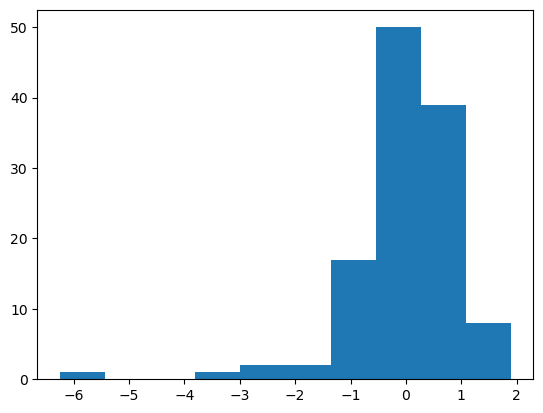

In [14]:
plt.hist(Y_train)

In [15]:
grid_n = 200
gamma_list = [800, 1000]
# gamma_list = [0.075, 0.1, 0.5]
lam_list = [0.1, 1, 5, 10]

run_time_dc  = 0
loc_error_dc = 0

np.random.seed(0)
print('---------- divide and conquer -----------')
start_time = time.time()
dcdp = dcdp_cv_grid_linear(grid_n, lam_list, gamma_list, smooth = 10,
             buffer = 10, step_refine = 1, buffer_refine = 10, lam_refine = 1)
cp_best, param_best, cp_best_cand = dcdp.fit((Y_train, X_train), (Y_test, X_test))
# loc_error_dc = cp_distance(cp_best, cp_truth)
run_time_dc = time.time() - start_time

print("time: {0}".format(run_time_dc))
print("best parameter: {0}".format(param_best))

---------- divide and conquer -----------
time: 19.21106505393982
best parameter: (5, 800)


In [16]:
print(cp_best)
print(cp_best_cand)

[48]
[52 63]


In [17]:
for cp in cp_best:
    print(fred["date"].values[2 * cp])

2008-01-01


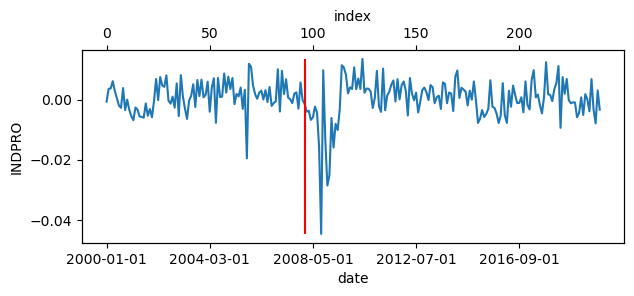

<Figure size 640x480 with 0 Axes>

In [18]:
n = fred.shape[0]
fig, ax = plt.subplots(1, 1, figsize = (7, 2.5))
ax.plot(fred.loc[:, "INDPRO"].values)

x = np.arange(0, n, 50)
y = [0] * len(x)
ax.xaxis.set_ticks(x)
for i, v in enumerate(x):
    if v < n:
        y[i] = fred.loc[:, "date"].values[int(v)]
    else:
        y[i] = ''
ax.set_xticklabels(y)
ax.set_xlabel('date')

ax2 = ax.twiny()
new_tick_locations = x.copy()

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(new_tick_locations)
ax2.set_xlabel("index")

ax.set_ylabel('INDPRO')

ymi, ymx = np.min(fred.loc[:, "INDPRO"].values), np.max(fred.loc[:, "INDPRO"].values)

ax.vlines([c * 2 for c in cp_best], ymi, ymx, colors = 'r')

plt.show()

plt.savefig('FRED_INDPRO-with-cp.pdf', bbox_inches = 'tight')